In [6]:
# here I prepare the data for Machine Learning

In [7]:
# this is a class that can be used to easuly import datasets from yahoo finance using panda datareaser.
# 
import numpy as np

# Create the class
class ImportData():

    # Initialize the class
    def __init__(self, symbol, start_date, end_date):
        self.df = self._extract_data(symbol, start_date, end_date)
        self.sharpe = 0

    # Extract data
    def _extract_data(self, symbol, start_date, end_date):
        from pandas_datareader.data import DataReader
        data = DataReader(name=symbol, data_source='yahoo', start=start_date, end=end_date)
        data = data[["Open", "High", "Low", "Close", "Volume"]]
        data = self._structure_df(data)
        return data

    # Calculates general period returns and volatility
    def _structure_df(self, df):
        df["Returns"] = df["Close"].pct_change()
        df["Range"] = df["High"] / df["Low"] - 1
        df["Bench_C_Rets"], sharpe = self._calculate_returns(df, True)
        self.sharpe = sharpe
        df.dropna(inplace=True)
        return df

    # Adjusts the signal to represent our strategy
    def _set_multiplier(self, direction):
        if direction == "long":
            pos_multiplier = 1
            neg_multiplier = 0
        elif direction == "long_short":
            pos_multiplier = 1
            neg_multiplier = -1
        else:
            pos_multiplier = 0
            neg_multiplier = -1
        return pos_multiplier, neg_multiplier

    # Calculates returns for equity curve
    def _calculate_returns(self, df, is_benchmark):
        
        # Calculate multiplier
        if not is_benchmark:
            multiplier_1 = df["Signal"]
            multiplier_2 = 1 if "PSignal" not in df.columns else df["PSignal"]
            log_rets = np.log(df["Close"] / df["Close"].shift(1)) * multiplier_1 * multiplier_2
        else:
            multiplier_1 = 1
            multiplier_2 = 1
            
            # Assume open price on following day to avoid lookahead bias for close calculation
            log_rets = np.log(df["Open"].shift(-1) / df["Close"].shift(1)) * multiplier_1 * multiplier_2
        
        # Calculate Sharpe Ratio
        sharpe_ratio = self.sharpe_ratio(log_rets)
        
        # Calculate Cumulative Returns
        c_log_rets = log_rets.cumsum()
        c_log_rets_exp = np.exp(c_log_rets) - 1
        
        # Return result and Sharpe ratio
        return c_log_rets_exp, sharpe_ratio
    
    def sharpe_ratio(self, return_series):
        N = 255 # Trading days in the year (change to 365 for crypto)
        rf = 0.005 # Half a percent risk free rare
        mean = return_series.mean() * N -rf
        sigma = return_series.std() * np.sqrt(N)
        sharpe = round(mean / sigma, 3)
        return sharpe

    # Replace Dataframe
    def change_df(self, new_df, drop_cols=[]):
        new_df = new_df.drop(columns=drop_cols)
        self.df = new_df

    # Moving average crossover strategy
    def backtest_ma_crossover(self, period_1, period_2, direction, drop_cols=[]):
        
        # Set df
        df = self.df
        
        # Get multipliers
        pos_multiplier, neg_multiplier = self._set_multiplier(direction)
            
        # Calculate Moving Averages
        if f"MA_{period_1}" or f"MA_{period_2}" not in df.columns:
            df[f"MA_{period_1}"] = df["Close"].rolling(window=period_1).mean()
            df[f"MA_{period_2}"] = df["Close"].rolling(window=period_2).mean()
            df.dropna(inplace=True)
        
        # Calculate Benchmark Returns
        df["Bench_C_Rets"], sharpe_ratio_bench = self._calculate_returns(df, True)
        
        # Calculate Signal
        df.loc[df[f"MA_{period_1}"] > df[f"MA_{period_2}"], "Signal"] = pos_multiplier
        df.loc[df[f"MA_{period_1}"] <= df[f"MA_{period_2}"], "Signal"] = neg_multiplier
        
        # Calculate Strategy Returns
        df["Strat_C_Rets"], sharpe_ratio_strat = self._calculate_returns(df, False)
        
        # Get values for output
        bench_rets = df["Bench_C_Rets"].values.astype(float)
        strat_rets = df["Strat_C_Rets"].values.astype(float)
        print("Sense check: ", round(df["Close"].values[-1] / df["Close"].values[0] - 1, 3), round(bench_rets[-1], 3))
        
        # Remove irrelevant features
        if len(drop_cols) > 0:
            df = df.drop(columns=drop_cols)
        
        # Ensure Latest DF matches
        df = df.dropna()
        self.df = df
        
        # Return df
        return df, sharpe_ratio_bench, sharpe_ratio_strat

In [8]:
import numpy as np
import pandas as pd
import sklearn.mixture as mix
#from ta.momentum import RSIIndicator
import matplotlib.pyplot as plt

In [9]:
# Extract Data
start_date = "2010-01-01"
end_date = "2022-09-29"
symbol = "BTC-USD"
imp_data = ImportData(symbol, start_date, end_date)
df = imp_data.df.copy()
df.tail(10)

,Open,High,Low,Close,Volume,Returns,Range,Bench_C_Rets
Date,,,,,,,,
2022-09-18,20127.234375,20127.234375,19387.492188,19419.505859,31254779144,-0.035179,0.038156,52.789455
2022-09-19,19418.572266,19639.480469,18390.318359,19544.128906,40177002624,0.006417,0.067925,53.138696
2022-09-20,19545.591797,19602.457031,18813.455078,18890.789062,36791346508,-0.033429,0.041938,51.330265
2022-09-21,18891.283203,19674.630859,18290.314453,18547.400391,46363793975,-0.018178,0.075686,50.343708
2022-09-22,18534.650391,19456.910156,18415.591797,19413.550781,41135767926,0.046699,0.056545,52.738238
2022-09-23,19412.400391,19464.671875,18617.552734,19297.638672,38896078052,-0.005971,0.045501,52.415590
2022-09-24,19296.990234,19310.197266,18861.974609,18937.011719,26149643168,-0.018688,0.023763,51.415439
2022-09-25,18936.310547,19134.732422,18696.468750,18802.097656,23359966112,-0.007124,0.023441,51.047002
2022-09-26,18803.900391,19274.873047,18721.285156,19222.671875,44148798321,0.022368,0.029570,52.208911


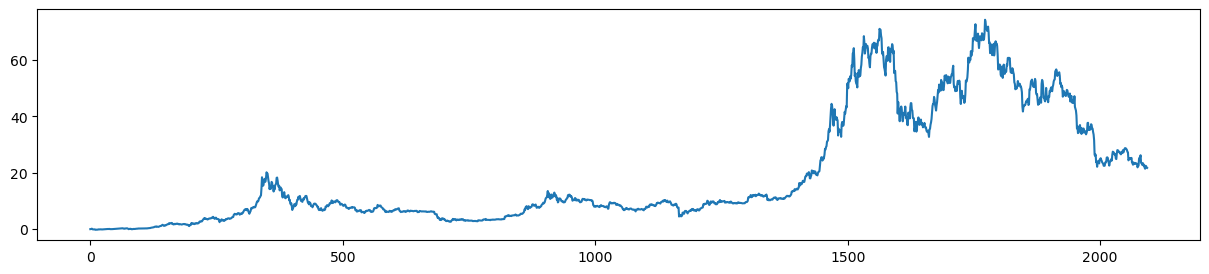

In [7]:
# Benchmark Returns Profile
fig = plt.figure(figsize = (15, 3))
plt.plot(df["Bench_C_Rets"].values)
plt.show()

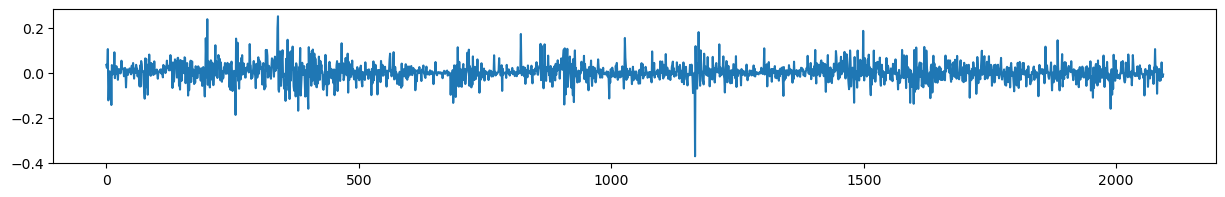

In [8]:
# Benchmark Returns Profile which is stationary and we can use for our ml model
fig = plt.figure(figsize = (15, 2))
plt.plot(df["Returns"].values)
plt.show()

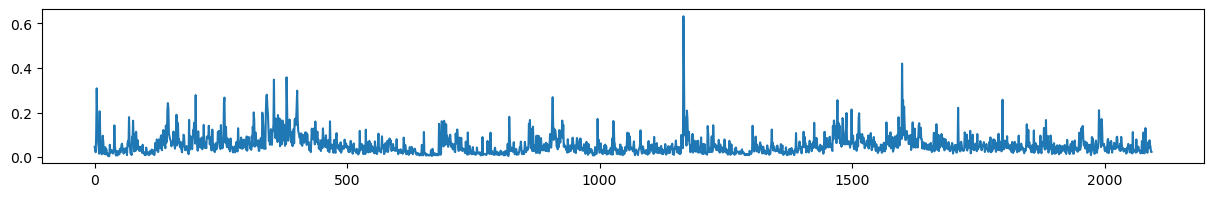

In [9]:
# Benchmark Range Profile also stationary
fig = plt.figure(figsize = (15, 2))
plt.plot(df["Range"].values)
plt.show()

In [10]:
# Feature Engineering - Feature Expansion
# Create a copy
df_fe = df.copy()

In [11]:
# Add RSI
rsi = RSIIndicator(close=df_fe["Close"], window=14).rsi()
df_fe["RSI"] = rsi
df_fe["RSI_Ret"] = df_fe["RSI"] / df_fe["RSI"].shift(1)

In [12]:
# Add Moving Average
df_fe["MA_12"] = df_fe["Close"].rolling(window=12).mean()
df_fe["MA_21"] = df_fe["Close"].rolling(window=21).mean()

In [13]:
# Day of Week
df_fe["DOW"] = df_fe.index.dayofweek

In [14]:
# Rolling Cumulative Returns
df_fe["Roll_Rets"] = df_fe["Returns"].rolling(window=30).sum()

In [15]:
# Rolling Cumulative Range
df_fe["Avg_Range"] = df_fe["Range"].rolling(window=30).mean()

In [16]:
# Time intervals for sequential importance in the data
# Add Time Intervals
t_steps = [1, 2]
t_features = ["Returns", "Range", "RSI_Ret"]
for ts in t_steps:
    for tf in t_features:
        df_fe[f"{tf}_T{ts}"] = df_fe[tf].shift(ts)

In [22]:
# Show DataFrame
df_fe.tail(3)

,Open,High,Low,Close,Volume,Returns,Range,Bench_C_Rets,RSI,RSI_Ret,...,MA_21,DOW,Roll_Rets,Avg_Range,Returns_T1,Range_T1,RSI_Ret_T1,Returns_T2,Range_T2,RSI_Ret_T2
Date,,,,,,,,,,,,,,,,,,,,,
2022-09-23,19412.400391,19464.671875,18617.552734,19297.638672,3.889608e+10,-0.005971,0.045501,22.357409,43.227946,0.982927,...,19978.217913,4,-0.084860,0.042373,0.046699,0.056545,1.211474,-0.018178,0.075686,0.949552
2022-09-24,19296.990234,19310.197266,18861.974609,18937.011719,2.614964e+10,-0.018688,0.023763,21.920066,40.888991,0.945893,...,19935.595238,5,-0.113171,0.042498,-0.005971,0.045501,0.982927,0.046699,0.056545,1.211474
2022-09-25,18936.310547,19134.732422,18696.468750,18802.097656,2.335997e+10,-0.007124,0.023441,21.758957,40.016659,0.978666,...,19879.184989,6,-0.058220,0.040630,-0.018688,0.023763,0.945893,-0.005971,0.045501,0.982927


In [23]:
# Feature Engineering - Feature Scaling
# Correct for Stationarity
df_fs = df_fe.copy()
df_fs[["Open", "High", "Low", "Volume"]] = df_fs[["Open", "High", "Low", "Volume"]].pct_change()
df_fs

,Open,High,Low,Close,Volume,Returns,Range,Bench_C_Rets,RSI,RSI_Ret,...,MA_21,DOW,Roll_Rets,Avg_Range,Returns_T1,Range_T1,RSI_Ret_T1,Returns_T2,Range_T2,RSI_Ret_T2
Date,,,,,,,,,,,,,,,,,,,,,
2017-01-01,NaN,NaN,NaN,998.325012,NaN,0.035883,0.046293,0.036186,NaN,NaN,...,NaN,6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-01-02,0.036277,0.028223,0.039640,1021.750000,0.503536,0.023464,0.034803,0.060344,NaN,NaN,...,NaN,0,NaN,NaN,0.035883,0.046293,NaN,NaN,NaN,NaN
2017-01-03,0.023015,0.012304,0.024980,1043.839966,-0.166604,0.021620,0.022005,0.083849,NaN,NaN,...,NaN,1,NaN,NaN,0.023464,0.034803,NaN,0.035883,0.046293,NaN
2017-01-04,0.022318,0.110471,0.022318,1154.729980,0.862881,0.106233,0.110130,0.201066,NaN,NaN,...,NaN,2,NaN,NaN,0.021620,0.022005,NaN,0.023464,0.034803,NaN
2017-01-05,0.107555,0.027324,-0.128287,1013.380005,0.479069,-0.122410,0.308302,0.054939,NaN,NaN,...,NaN,3,NaN,NaN,0.106233,0.110130,NaN,0.021620,0.022005,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-09-21,-0.033476,0.003682,-0.027807,18547.400391,0.260182,-0.018178,0.075686,21.451423,36.301870,0.949552,...,20044.204706,2,-0.125733,0.040995,-0.033429,0.041938,0.906138,0.006417,0.067925,1.026282
2022-09-22,-0.018878,-0.011066,0.006849,19413.550781,-0.112761,0.046699,0.056545,22.498496,43.978781,1.211474,...,20010.224237,3,-0.085071,0.041781,-0.018178,0.075686,0.949552,-0.033429,0.041938,0.906138
2022-09-23,0.047357,0.000399,0.010967,19297.638672,-0.054446,-0.005971,0.045501,22.357409,43.227946,0.982927,...,19978.217913,4,-0.084860,0.042373,0.046699,0.056545,1.211474,-0.018178,0.075686,0.949552


In [24]:
# Assess Data for ML Readiness

In [25]:
# Check for NaN
#df_fs.dropna(inplace=True)
print(df_fs.isnull().values.any())

False


In [27]:
df_fs.dropna(inplace=True)
print(df_fs.isnull().values.any())

False


In [28]:
# Check for Inf values
dfobj = df_fs.isin([np.inf, -np.inf])
count = np.isinf(dfobj).values.sum()
count

0

In [29]:
# Check for non-numerical objects
df_fs.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2065 entries, 2017-01-30 to 2022-09-25
Data columns (total 21 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Open          2065 non-null   float64
 1   High          2065 non-null   float64
 2   Low           2065 non-null   float64
 3   Close         2065 non-null   float64
 4   Volume        2065 non-null   float64
 5   Returns       2065 non-null   float64
 6   Range         2065 non-null   float64
 7   Bench_C_Rets  2065 non-null   float64
 8   RSI           2065 non-null   float64
 9   RSI_Ret       2065 non-null   float64
 10  MA_12         2065 non-null   float64
 11  MA_21         2065 non-null   float64
 12  DOW           2065 non-null   int64  
 13  Roll_Rets     2065 non-null   float64
 14  Avg_Range     2065 non-null   float64
 15  Returns_T1    2065 non-null   float64
 16  Range_T1      2065 non-null   float64
 17  RSI_Ret_T1    2065 non-null   float64
 18  Returns_T2

In [30]:
# Describe DataFrame
df_fs.describe()

,Open,High,Low,Close,Volume,Returns,Range,Bench_C_Rets,RSI,RSI_Ret,...,MA_21,DOW,Roll_Rets,Avg_Range,Returns_T1,Range_T1,RSI_Ret_T1,Returns_T2,Range_T2,RSI_Ret_T2
count,2065.000000,2065.000000,2065.000000,2065.000000,2065.000000,2065.000000,2065.000000,2065.000000,2065.000000,2065.000000,...,2065.000000,2065.000000,2065.000000,2065.000000,2065.000000,2065.000000,2065.000000,2065.000000,2065.000000,2065.000000
mean,0.002313,0.002108,0.002335,17827.964216,0.034148,0.002312,0.054253,19.447922,52.781098,1.005173,...,17737.393222,3.000000,0.070332,0.054235,0.002314,0.054244,1.005179,0.002324,0.054234,1.005208
std,0.041055,0.035942,0.041366,17124.056558,0.285843,0.041058,0.044837,19.806415,14.533497,0.105371,...,17067.137012,2.000484,0.252125,0.024277,0.041058,0.044846,0.105370,0.041055,0.044854,0.105362
min,-0.365924,-0.263712,-0.364062,920.382019,-0.869188,-0.371695,0.003887,-0.046710,9.920239,0.453659,...,882.626665,0.000000,-0.844981,0.015818,-0.371695,0.003887,0.453659,-0.371695,0.003887,0.453659
25%,-0.015799,-0.012583,-0.012669,6409.220215,-0.124434,-0.016012,0.026479,6.258508,42.420975,0.953251,...,6473.119768,1.000000,-0.093079,0.037026,-0.016012,0.026479,0.953251,-0.015948,0.026479,0.953671
50%,0.001927,-0.000097,0.003116,9477.641602,-0.009132,0.002022,0.042676,9.588353,51.842473,1.005243,...,9398.508231,3.000000,0.044506,0.049104,0.002022,0.042676,1.005243,0.002022,0.042676,1.005269
75%,0.020435,0.016046,0.019191,29283.103516,0.145560,0.020426,0.066142,34.201948,62.632320,1.047581,...,29750.548456,5.000000,0.235439,0.065699,0.020426,0.066142,1.047581,0.020426,0.066142,1.047581
max,0.250461,0.245708,0.247892,67566.828125,5.439003,0.252472,0.631387,74.273698,94.302215,1.926078,...,63016.876488,6.000000,1.154731,0.138628,0.252472,0.631387,1.926078,0.252472,0.631387,1.926078


In [31]:
# Save DataFrame
df_fs.to_csv(f"data/{symbol}.csv")